In [2]:
%load_ext autoreload
%autoreload 2

In [1]:
import os
import sys
import pickle
import numpy as np
import torch
import pandas as pd
sys.path.append("/home/wangrr/Analysis/epiRNA/src")
import epiRNA as erna

workdir = "/data/wangrr/Analysis/epiRNA/workdir2/others"
os.makedirs(workdir, exist_ok=True); os.chdir(workdir)

import matplotlib.pyplot as plt
plt.rcParams.update({
    'font.family': 'sans-serif',
    'font.sans-serif': ['Arial'],
    'font.size': 12,
    'axes.linewidth': 1.5,
    'axes.labelweight': 'bold',
    'axes.titleweight': 'bold',
    'xtick.major.width': 1.5,
    'ytick.major.width': 1.5,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12
})

/nvme/biosoft/miniforge3/envs/wrr_m6a_env/lib/python3.11/site-packages/sorted_nearest/__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [3]:
checkpoints = "/data/wangrr/Analysis/epiRNA/models/basic_fold/version_0/checkpoints/epoch=18-step=215327-val_ePCC_mixed=0.7823.ckpt"
config_file = "/home/wangrr/Analysis/epiRNA/src/experiments/model_v2/configs/basic_model.yaml"
model = erna.evals.load_model(ckpt=checkpoints, config_yaml=config_file)

In [4]:
datainfo = pd.read_excel("/home/wangrr/Analysis/epiRNA/data/mRNA_multiomic_sample_info.xlsx", sheet_name="m6A")

m6A_train_samples = ["Adipose-1", "Aorta-1", "Appendix-1", "Esophagus-1", "GOS-1", "Hela-1", "HT29-1", "Hypothalamus-1", "Jejunum-1", "Liver-1", "Prostate-1", "Skin-1", "Testis-1", "Tongue-1", "Trachea-1", "WPMY-1", "MT4-1", "GSC11-1", "iSLK-1", "TIME-1", "mHeart-1", "mSpleen-1", "mLung-1", "mLiver-1", "mCerebrum-1", "mCerebellum-1", "mBrainstem-1", "mHypothalamus-1", "mBMDC-1", "mEF-1", "mNPC-1", "mESC-1", "mStriatum-1", "mPeritoneal_macrophages-1", "mB16-OVA-1", "miPSC-1", "mNSC-1", "mForebrain-1", "mKidney-1", "mHypothalamus-2"]

datainfo = datainfo[datainfo["SID"].isin(m6A_train_samples)].reset_index(drop=True)

ref_dir = "/data/wangrr/Analysis/epiRNA/Dataset/Reference"
genome = {
    "human":{
        "fasta": f"{ref_dir}/Homo_sapiens.GRCh38.dna.primary_assembly.84.fa",
        "gtf": f"{ref_dir}/Homo_sapiens.GRCh38.84.gtf"
    },
    "mouse":{
        "fasta": f"{ref_dir}//Mus_musculus.GRCm38.dna.primary_assembly.84.fa",
        "gtf": f"{ref_dir}/Mus_musculus.GRCm38.84.gtf"
    }
}
chrom_kwargs = {
    'human': {
        'train_chroms': ["1", "2", "3", "4", "5", "6", "7", "9", "11", "12", "13", "14", "15", "16", "17", "18", "19", "20", "21", "22"],
        'val_chroms': ["8"],
        'test_chroms': ["10"]
    },
    'mouse': {
        'train_chroms': ["1", "2", "3", "4", "5", "6", "7", "9", "11", "12", "13", "14", "15", "16", "17", "18", "19"],
        'val_chroms': ["8"],
        'test_chroms': ["10"]
    }
}

In [5]:
human_gtf_df = erna.pp.GTFLoader(gtf_path=genome["human"]["gtf"], zero_based=True)
mouse_gtf_df = erna.pp.GTFLoader(gtf_path=genome["mouse"]["gtf"], zero_based=True)
full_human_gtf_df = erna.pp.GTFLoader(gtf_path=genome["human"]["gtf"], zero_based=True, keep_all_features=True)
full_mouse_gtf_df = erna.pp.GTFLoader(gtf_path=genome["mouse"]["gtf"], zero_based=True, keep_all_features=True)

INFO:root:Extracted GTF attributes: ['gene_id', 'gene_version', 'gene_name', 'gene_source', 'gene_biotype', 'havana_gene', 'havana_gene_version', 'transcript_id', 'transcript_version', 'transcript_name', 'transcript_source', 'transcript_biotype', 'havana_transcript', 'havana_transcript_version', 'tag', 'transcript_support_level', 'exon_number', 'exon_id', 'exon_version', 'ccds_id', 'protein_id', 'protein_version']
INFO:root:Extracted GTF attributes: ['gene_id', 'gene_version', 'gene_name', 'gene_source', 'gene_biotype', 'havana_gene', 'havana_gene_version', 'transcript_id', 'transcript_version', 'transcript_name', 'transcript_source', 'transcript_biotype', 'havana_transcript', 'havana_transcript_version', 'tag', 'transcript_support_level', 'exon_number', 'exon_id', 'exon_version', 'ccds_id', 'protein_id', 'protein_version']
INFO:root:Extracted GTF attributes: ['gene_id', 'gene_version', 'gene_name', 'gene_source', 'gene_biotype', 'havana_gene', 'havana_gene_version', 'transcript_id', '

In [6]:
rbp_dict_file = "/home/wangrr/Analysis/epiRNA/data/rbp_expression_dict.pkl"
with open(rbp_dict_file, "rb") as f:
    rbp_dict = pickle.load(f)['rbp_dict']

human_fasta_loader = erna.pp.FastaLoader(genome["human"]["fasta"])
mouse_fasta_loader = erna.pp.FastaLoader(genome["mouse"]["fasta"])

mouse_generator = erna.pp.DataGenerator(
    fasta_loader=mouse_fasta_loader,
    gtf_df=mouse_gtf_df,
    seq_len=65536,
    bin_size=64
)

human_generator = erna.pp.DataGenerator(
    fasta_loader=human_fasta_loader,
    gtf_df=human_gtf_df,
    seq_len=65536,
    bin_size=64
)

bigwig_dir = "/data/wangrr/Analysis/epiRNA/Dataset/processed/4-coverage"

In [7]:
def get_signal_data(sample, gene):
    signal_data_list = []
    data = erna.evals.benchmarks.get_predict_stats(
        model=model,
        rbp_dict=rbp_dict,
        datainfo=datainfo,
        gtf_df=human_gtf_df,
        generator=human_generator,
        sample_name=sample,
        gene_name=gene,
        bigwig_dir=bigwig_dir,
        mask_type=None,
        device='cuda:0' if torch.cuda.is_available() else 'cpu'
    )
    
    signal_data_list.append({
            "signal_array": data["preds"],
            "chrom": data["chrom"],
            "start": data["requested_start"],
            "end": data["requested_end"],
            "strand": data["strand"],
            "label": "pred_IP"
        })
    signal_data_list.append({
        "signal_array": data["target"],
        "chrom": data["chrom"],
        "start": data["requested_start"],
        "end": data["requested_end"],
        "strand": data["strand"],
        "label": "obs_IP"
    })
    signal_data_list.append({
        "signal_array": data["bin_input"],
        "chrom": data["chrom"],
        "start": data["requested_start"],
        "end": data["requested_end"],
        "strand": data["strand"],
        "label": "obs_Input"
    })
    return signal_data_list

In [8]:
chrom_list = ["8", "10"]
full_selected_gtf = full_human_gtf_df[full_human_gtf_df['chrom'].isin(chrom_list)]
selected_gtf = human_gtf_df[human_gtf_df['chrom'].isin(chrom_list)]

In [ ]:
# Load all signal data
from tqdm import tqdm

signal_data_list = []
samples = ["Hela-1", "GOS-1", "TIME-1"]
for sample in samples:
    for i, row in tqdm(selected_gtf.iterrows()):
        gene = row['gene_name']
        signal_data_list = signal_data_list + get_signal_data(sample, gene)

11it [00:00, 31.34it/s]

867it [00:27, 31.25it/s]

In [ ]:
import epiRNA as erna
analyzer = erna.ex.GenomicRegionAnalyzer(gtf_df=full_selected_gtf)

Processing GTF: 100%|██████████| 228050/228050 [00:04<00:00, 49177.75it/s]

Finished, containing 2 chromosomes with gene regions.
Pass pickle test for GTF data structure.


In [ ]:
bin_collections = analyzer.batch_process_signals_dual(signal_data_list, n_jobs=32)

Processing 4194 samples for dual-level analysis using 32 threads.


Processing signals: 100%|██████████| 4194/4194 [15:50<00:00,  4.41it/s]


In [ ]:
enrichment_df = analyzer.aggregate_gene_enrichment_by_label(bin_collections[1])
mean_cols = [col for col in enrichment_df.columns if "mean" in col]
plot_df = enrichment_df[mean_cols]
plot_df.columns = [col[0] for col in plot_df.columns]
plot_df = plot_df.loc[['pred_IP', 'obs_IP', 'obs_Input'], :]
# Rename rows for better visualization
plot_df.index = ['Predicted IP', 'Observed IP', 'Observed Input']
# Rename columns for better visualization
plot_df.columns = ['CDS', '5\'UTR', '3\'UTR', 'Intron', 'Stop codon', 'Start codon']

# zscore normalization
plot_df = plot_df.apply(lambda x: (x - x.mean()) / x.std(), axis=1)

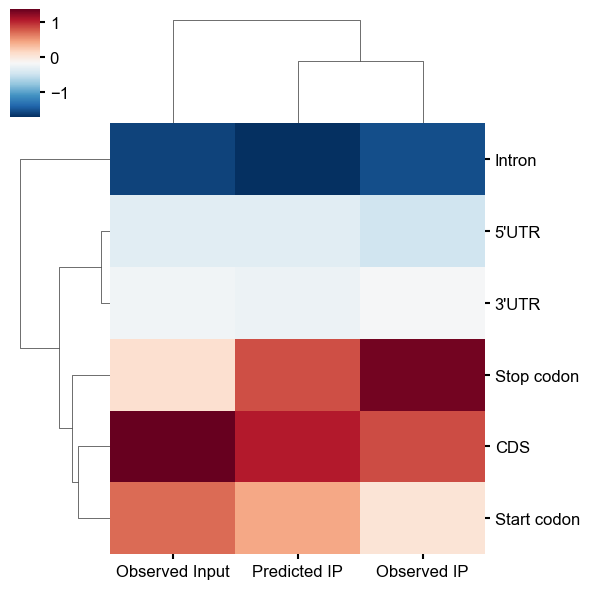

In [ ]:
# change dpi
import seaborn as sns
sns.clustermap(plot_df.T, cmap='RdBu_r', figsize=(6, 6), )
plt.xlabel('Samples')
plt.show()


Text(0.5, -56.527777777777736, '')

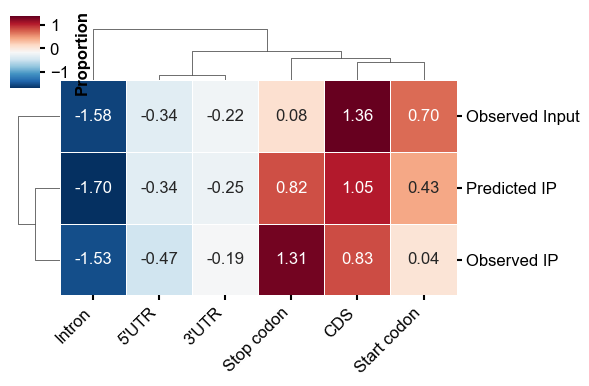

In [ ]:
import seaborn as sns

g = sns.clustermap(
    plot_df, 
    cmap='RdBu_r', 
    figsize=(6, 4), 
    annot=True,           # 在单元格中显示数值
    fmt='.2f',            # 数值格式化为两位小数
    linewidths=.5,        # 添加单元格之间的线条
    dendrogram_ratio=(.1, .2),  # 调整行和列的树状图大小比例
    cbar_kws={'label': 'Proportion'} # 为颜色条添加标签
)
plt.setp(g.ax_heatmap.get_xticklabels(), rotation=45, ha='right') # 旋转X轴标签
g.ax_heatmap.set_ylabel('') # 移除Y轴的 "Samples" 标签
g.ax_heatmap.set_xlabel('') # 移除X轴的默认标签